<a href="https://colab.research.google.com/github/Piyush-jain-2487/MWCNN/blob/master/MWCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import gc


In [ ]:
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
def default_conv(in_channels, out_channels, kernel_size, bias=True, dilation=1):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2)+dilation-1, bias=bias, dilation=dilation)

In [ ]:
def dwt_init(x):

    x01 = x[:, :, 0::2, :] / 2
    x02 = x[:, :, 1::2, :] / 2
    x1 = x01[:, :, :, 0::2]
    x2 = x02[:, :, :, 0::2]
    x3 = x01[:, :, :, 1::2]
    x4 = x02[:, :, :, 1::2]
    x_LL = x1 + x2 + x3 + x4
    x_HL = -x1 - x2 + x3 + x4
    x_LH = -x1 + x2 - x3 + x4
    x_HH = x1 - x2 - x3 + x4

    return torch.cat((x_LL, x_HL, x_LH, x_HH), 1)

In [ ]:
def iwt_init(x):
    r = 2
    in_batch, in_channel, in_height, in_width = x.size()
    out_batch, out_channel, out_height, out_width = in_batch, int(
        in_channel / (r ** 2)), r * in_height, r * in_width
    x1 = x[:, 0:out_channel, :, :] / 2
    x2 = x[:, out_channel:out_channel * 2, :, :] / 2
    x3 = x[:, out_channel * 2:out_channel * 3, :, :] / 2
    x4 = x[:, out_channel * 3:out_channel * 4, :, :] / 2
    

    h = torch.zeros([out_batch, out_channel, out_height, out_width]).float()

    h[:, :, 0::2, 0::2] = x1 - x2 - x3 + x4
    h[:, :, 1::2, 0::2] = x1 - x2 + x3 - x4
    h[:, :, 0::2, 1::2] = x1 + x2 - x3 - x4
    h[:, :, 1::2, 1::2] = x1 + x2 + x3 + x4

    return h

In [ ]:
class DWT(nn.Module):
    def __init__(self):
        super(DWT, self).__init__()
        self.requires_grad = False

    def forward(self, x):
        return dwt_init(x)

class IWT(nn.Module):
    def __init__(self):
        super(IWT, self).__init__()
        self.requires_grad = False

    def forward(self, x):
        return iwt_init(x)
 

In [ ]:
class BBlock(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, act=nn.ReLU(True), res_scale=1):

        super(BBlock, self).__init__()
        m = []
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias))
        m.append(act)


        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x).mul(self.res_scale)
        return x

In [ ]:
class DBlock(nn.Module):
    def __init__(
        self, conv, in_channels, out_channels, kernel_size,
        bias=True, act=nn.ReLU(True), res_scale=1,one=2,two=1):

        super(DBlock, self).__init__()
        m = []
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=one))
        m.append(act)
        m.append(conv(in_channels, out_channels, kernel_size, bias=bias, dilation=two))
        m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        x = self.body(x)
        return x

In [ ]:
class MWCNN(nn.Module):
    def __init__(self, conv=default_conv):
        super(MWCNN, self).__init__()
        n_feats = 64
        kernel_size = 3
        self.scale_idx = 0
        nColor = 1
        self.DWT = DWT()
        self.IWT = IWT()

        n = 1
        m_head = [BBlock(conv, nColor, n_feats, kernel_size)]
        
        d_l0 = []
        d_l0.append(DBlock(conv, n_feats, n_feats, kernel_size))


        d_l1 = [BBlock(conv, n_feats * 4, n_feats * 2, kernel_size)]
        d_l1.append(DBlock(conv, n_feats * 2, n_feats * 2, kernel_size))

        d_l2 = []
        d_l2.append(BBlock(conv, n_feats * 8, n_feats * 4, kernel_size))
        d_l2.append(DBlock(conv, n_feats * 4, n_feats * 4, kernel_size))
        
        pro_l3 = []
        
        pro_l3.append(BBlock(conv, n_feats * 16, n_feats * 8, kernel_size))
        pro_l3.append(DBlock(conv, n_feats * 8, n_feats * 8, kernel_size,two=3))
        
        pro_l3.append(DBlock(conv, n_feats * 8, n_feats * 8, kernel_size,one=3,two=2))
        pro_l3.append(BBlock(conv, n_feats * 8, n_feats * 16, kernel_size))

        i_l2 = [DBlock(conv, n_feats * 4, n_feats * 4, kernel_size)]
        i_l2.append(BBlock(conv, n_feats * 4, n_feats * 8, kernel_size))

        i_l1 = [DBlock(conv, n_feats * 2, n_feats * 2, kernel_size)]
        i_l1.append(BBlock(conv, n_feats * 2, n_feats * 4, kernel_size))

        i_l0 = [DBlock(conv, n_feats, n_feats, kernel_size)]

        m_tail = [conv(n_feats, nColor, kernel_size)]

        self.head = nn.Sequential(*m_head)
        self.d_l2 = nn.Sequential(*d_l2)
        self.d_l1 = nn.Sequential(*d_l1)
        self.d_l0 = nn.Sequential(*d_l0)
        self.pro_l3 = nn.Sequential(*pro_l3)
        self.i_l2 = nn.Sequential(*i_l2)
        self.i_l1 = nn.Sequential(*i_l1)
        self.i_l0 = nn.Sequential(*i_l0)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        x0 = self.d_l0(self.head(x))
        x1 = self.d_l1(self.DWT(x0))
        x2 = self.d_l2(self.DWT(x1))
        x_ = self.IWT(self.pro_l3(self.DWT(x2))) + x2
        x_ = self.IWT(self.i_l2(x_)) + x1
        x_ = self.IWT(self.i_l1(x_)) + x0
        x = self.tail(self.i_l0(x_)) + x

        return x

    def set_scale(self, scale_idx):
        self.scale_idx = scale_idx



In [ ]:
model=MWCNN()
model.load_state_dict(torch.load('./sample_data/MWCNN_denoising_50.pt',map_location=torch.device('cpu')))
model.eval()

MWCNN(
  (DWT): DWT()
  (IWT): IWT()
  (head): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
  )
  (d_l2): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): DBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (d_l1): Sequential(
    (0): BBlock(
      (body): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (1): DBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_si

In [ ]:
from PIL import Image

In [ ]:
imgr,imgg,imgb=Image.open('./sample_data/dada.jpeg').convert('RGB').split()
imgt=Image.open('./sample_data/dada.jpeg').convert('RGB')

In [ ]:
imgt.size

(1016, 1024)

In [ ]:
def imgformat(img):    
    width,height=img.size
    csize=192
    if width<height:csize=width-(width%192)
    elif height<width:csize=height-(height%192)
    if min(width,height) in [512,1024,256]:csize=min(width,height)
    left = (width - csize)/2
    top = (height - csize)/2
    right = (width + csize)/2
    bottom = (height + csize)/2
    img = img.crop((left, top, right, bottom))
    img=np.array(img)
    img=img[np.newaxis,:]
    img=img[np.newaxis,:]
    img= torch.from_numpy(img)
    img = img.float()/255.0
    return img

In [ ]:
imgr=imgformat(imgr)
imgg=imgformat(imgg)
imgb=imgformat(imgb)
imager=model(imgr)
imgr=None
gc.collect()
imageg=model(imgg)
imgg=None
gc.collect()
imageb=model(imgb)
imgb=None
gc.collect()

0

In [ ]:
imager=imager.cpu().detach().numpy().squeeze()*255.0
imageg=imageg.cpu().detach().numpy().squeeze()*255.0
imageb=imageb.cpu().detach().numpy().squeeze()*255.0

In [ ]:
imager=Image.fromarray(imager.astype(np.uint8))
imageg=Image.fromarray(imageg.astype(np.uint8))
imageb=Image.fromarray(imageb.astype(np.uint8))
rgb=Image.merge('RGB',(imager,imageg,imageb))

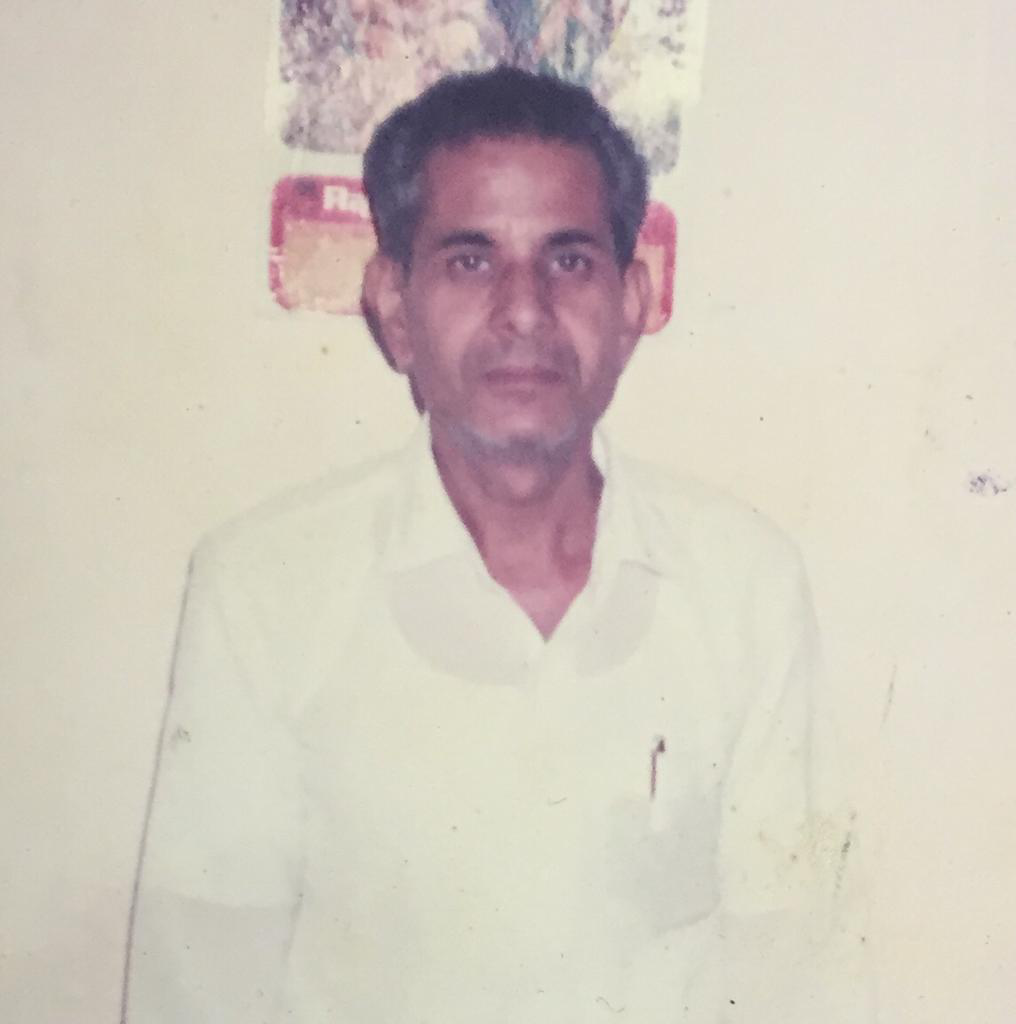

In [ ]:
#imk=Image.fromarray((img.cpu().detach().squeeze().numpy()*255).astype(np.uint8),'L')
imgt

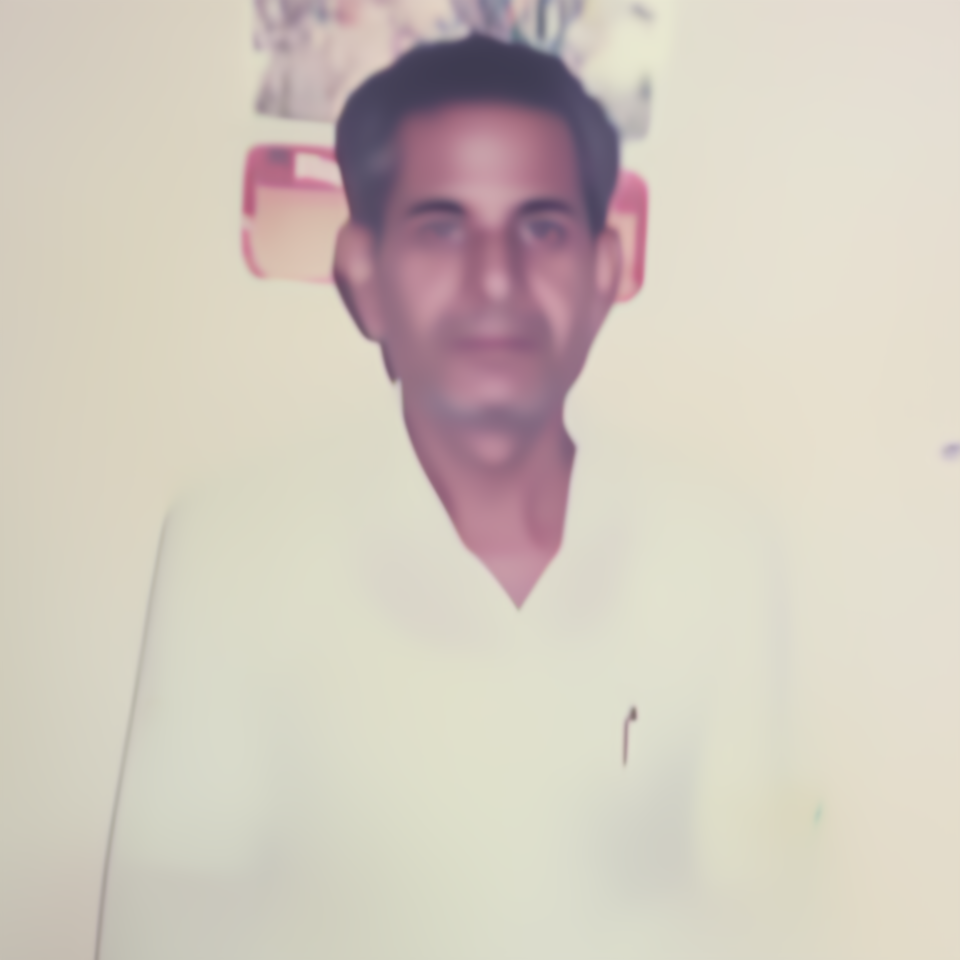

In [ ]:
rgb

In [ ]:
rgb.size

(576, 576)